<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 10th exercise: <font color="#C70039">Interpretable Machine Learning by means of Shapley Values</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: Finn Heydemann
* Date:   08.08.2023

<img src="https://shap.readthedocs.io/en/latest/_images/example_notebooks_overviews_An_introduction_to_explainable_AI_with_Shapley_values_13_0.png" style="float: center;" width="600">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation please use English language, too.
* This applies to all exercises throughout this course.

---------------------------------

### <font color="ce33ff">DESCRIPTION</font>:

Before using Shapley values to explain complicated models, it is helpful to understand how they work for simple models.

In this respect the example in this notebook computes a model for the titanic data set (downloaded from Kaggle) and uses its outputs for explanation of feature importance using SHAP deepexplainer. In addition, several different visualization techniques (plots) for Shapley values are going to be demonstrated. 

For a description of the features please refer to <a href="https://www.kaggle.com/competitions/titanic/data">Kaggle Titanic data set</a>.

---------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done by using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully 
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time. 
4. Develop a CNN for image classification and adapt the Shapley Value idea to that model. Comment your entire code.  
---------------------------------

## Imports
Import all necessary python utilities.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
import os
%matplotlib inline
import shap
import warnings 
warnings.filterwarnings('ignore')

2023-12-11 20:55:28.165205: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## load build-in dataset
take the titanic data set

In [2]:
os.chdir('data/titanic')
train_data = pd.read_csv('./train.csv', index_col=0)
test_data = pd.read_csv('./test.csv', index_col=0)
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Preprocessing
Since the titanic data is a raw data set there is a need to preprocess it by dropping unnecessary columns, handling missing data, converting categorical features to numeric features and conducting one-hot encoding.

In [3]:
def data_preprocessing(df):
    
    df = df.drop(columns=['Name', 'Ticket', 'Cabin'])
    
    # fill na
    df[['Age']] = df[['Age']].fillna(value=df[['Age']].mean())
    df[['Embarked']] = df[['Embarked']].fillna(value=df['Embarked'].value_counts().idxmax())
    df[['Fare']] = df[['Fare']].fillna(value=df[['Fare']].mean())
    
    # encode categorical features into numeric
    df['Sex'] = df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
    
    # one-hot encoding
    embarked_one_hot = pd.get_dummies(df['Embarked'], prefix='Embarked')
    
    df = df.drop('Embarked', axis=1)
    df = df.join(embarked_one_hot)
    
    return df


In [4]:
# training data processing
train_data = data_preprocessing(train_data)
train_data.isnull().sum()

# create data for training
x_train = train_data.drop(['Survived'], axis=1).values

# Check testing data
test_data.isnull().sum()

# normalize training data
scale = StandardScaler()
x_train = scale.fit_transform(x_train)

# prepare y_train
y_train = train_data['Survived'].values

# preprocess testing data
test_data = data_preprocessing(test_data)
x_test = test_data.values.astype(float)

# normalize testing data
x_test = scale.transform(x_test)

# Check testing data
test_data.isnull().sum()

Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

### Build a simple vanilla ANN, compile and fit the model.

In [6]:
x_train.min()

-2.2531554887793948

In [5]:
model = Sequential()
model.add(Dense(32, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))

# compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# fit model
model.fit(x_train, y_train, epochs=100, batch_size=64)

Epoch 1/100


2023-12-11 20:54:21.673713: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


14/14 [==============================] - 1s 3ms/step - loss: 0.6937 - accuracy: 0.5320
Epoch 2/100
14/14 [==============================] - 0s 3ms/step - loss: 0.6680 - accuracy: 0.6431
Epoch 3/100
14/14 [==============================] - 0s 3ms/step - loss: 0.6369 - accuracy: 0.6386
Epoch 4/100
14/14 [==============================] - 0s 6ms/step - loss: 0.5934 - accuracy: 0.6902
Epoch 5/100
14/14 [==============================] - 0s 4ms/step - loss: 0.5533 - accuracy: 0.7464
Epoch 6/100
14/14 [==============================] - 0s 5ms/step - loss: 0.5354 - accuracy: 0.7699
Epoch 7/100
14/14 [==============================] - 0s 6ms/step - loss: 0.5076 - accuracy: 0.7823
Epoch 8/100
14/14 [==============================] - 0s 3ms/step - loss: 0.5011 - accuracy: 0.7845
Epoch 9/100
14/14 [==============================] - 0s 3ms/step - loss: 0.5170 - accuracy: 0.7688
Epoch 10/100
14/14 [==============================] - 0s 3ms/step - loss: 0.4998 - accuracy: 0.8058
Epoch 11/100
14/14 [=

### Now, compute the Shapley values

In [6]:
explainer = shap.DeepExplainer(model, x_train)
shap_values = explainer.shap_values(x_test)

### Shapley values interpretation 
#### Global interpretation method

The summary plot shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

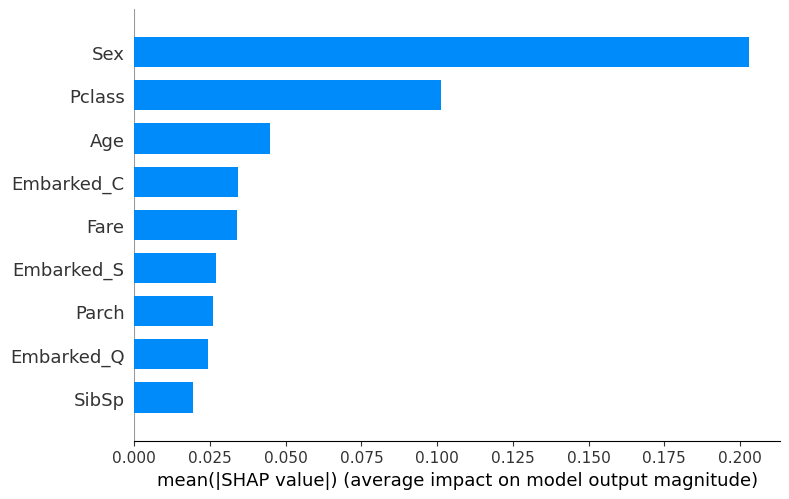

In [7]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = test_data.columns)

#### Local Interpretation methods
##### Force plot
The force plot is great for seeing where the “output value” fits in relation to the “base value”. 
Further, it is possible to observe which features have a positive (red) or negative (blue) impact on the prediction and in addition the magnitude of the impact.

In [8]:
shap.initjs()

1/1 [==============================] - 0s 69ms/step
[[0.04037515 0.9596249 ]]
Pclass            2
Sex               1
Age            0.92
SibSp             1
Parch             2
Fare          27.75
Embarked_C    False
Embarked_Q    False
Embarked_S     True
Name: 1142, dtype: object


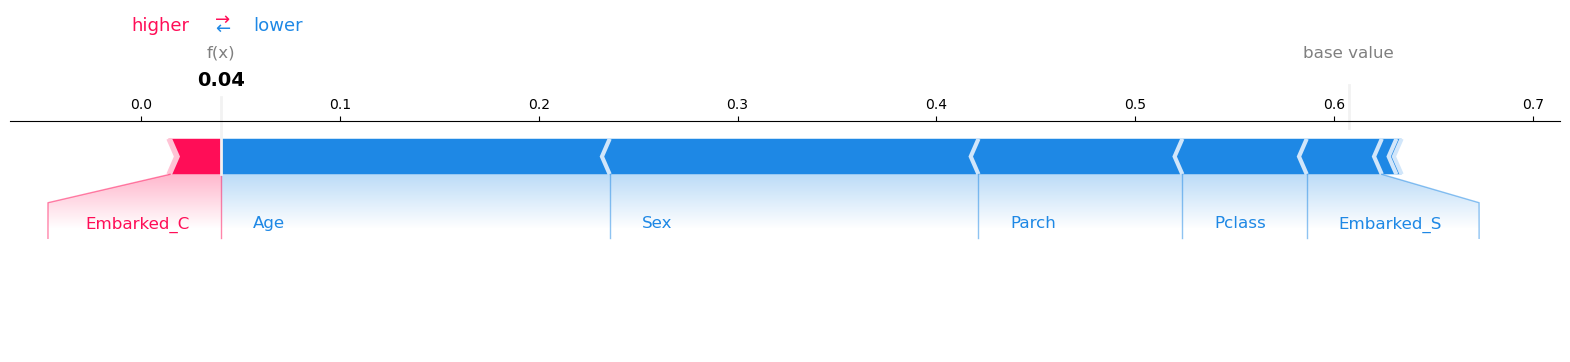

In [9]:
i = 250
print(model.predict(x_test[i:i+1]))
print(test_data.iloc[i])
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][i], features = test_data.columns, matplotlib=True)

##### Decision plot
The decision plot enables to observe the amplitude of each change taken by a sample for the values of the displayed features.

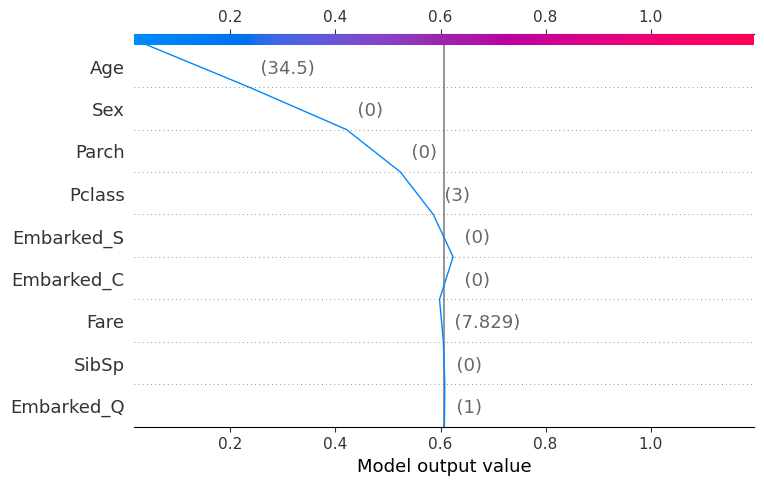

In [10]:
shap.decision_plot(explainer.expected_value[0].numpy(), shap_values[0][i], features = test_data.iloc[0,:], 
                   feature_names = test_data.columns.tolist())

##### Waterfall plot
The waterfall plot allows for seeing the amplitude and the nature of the impact of a feature. 
It also allows for seeing the order of importance of the features and the values taken by each feature for the sample.

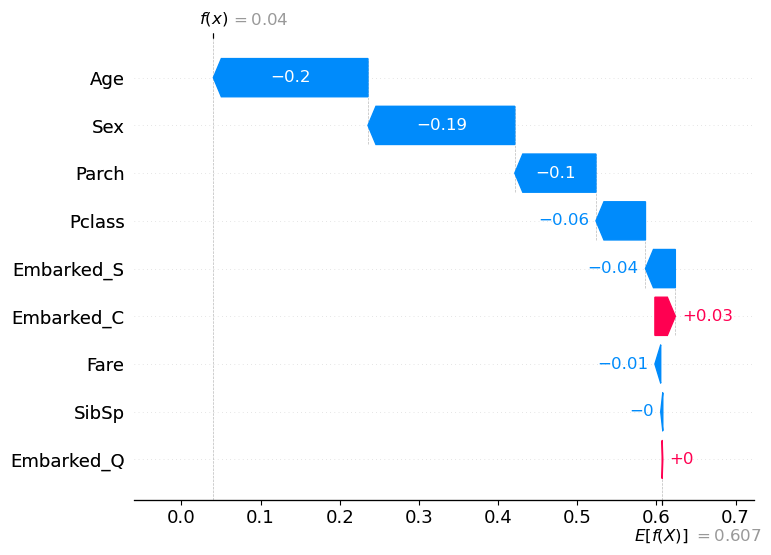

In [11]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0].numpy(), shap_values[0][i], 
                                       feature_names = test_data.columns)

In [12]:
x = x_test[250]
x

array([-0.36936484,  1.35557354, -2.21467831,  0.43279337,  2.00893337,
       -0.08968408, -0.48204268, -0.30756234,  0.61583843])

In [13]:
j = 4
M = 1000
n_features = len(x)

In [14]:
feature_idxs = list(range(n_features))
feature_idxs.remove(j)
feature_idxs

[0, 1, 2, 3, 5, 6, 7, 8]

In [15]:
xx = []
yy = []

for _ in range(M):
    z = x_train[1, :]
    
    x_idx = np.random.choice(feature_idxs, min(max(int(0.2*n_features), 
                                                   np.random.choice(feature_idxs)), int(0.8*n_features)), replace=False).tolist()
    z_idx = [idx for idx in feature_idxs if idx not in x_idx]
    # construct two new instances
    x_plus_j = np.array([x[i] if i in x_idx + [j] else z[i] for i in range(n_features)])
    x_minus_j = np.array([z[i] if i in z_idx + [j] else x[i] for i in range(n_features)])
    xx.append(x_plus_j)
    yy.append(x_minus_j)
    
xx = np.vstack(xx)
yy = np.vstack(yy)

diff = model.predict(yy)[:, 0] - model.predict(xx)[:, 0]
diff = np.sum(diff) / len(diff)
diff

32/32 [==============================] - 0s 2ms/step


-0.020311967849731445

In [16]:
x_train.max()

9.667166525013505

In [12]:
def get_permutations(in1, in2, feat_idx): 
    n_feat = len(in1)
    permutation = np.random.permutation([f for f in range(n_feat) if f != feat_idx])
    permutation = np.insert(permutation, feat_idx, feat_idx)
    # permutation = np.array([2, 3, 0, 1])
    in1 = in1[permutation]
    in2 = in2[permutation]
    split_idx = np.where(permutation == feat_idx)[0][0]
    return np.append(in1[:(split_idx + 1)], in2[(split_idx + 1):]), np.append(in1[:split_idx], in2[split_idx:])
    

i1 = np.array([18, 4, 2, 3])
i2 = np.array([25, 0, 2, 0])
get_permutations(i1, i2, 2)

(array([ 3, 18,  2,  0]), array([ 3, 18,  2,  0]))

In [13]:
in1 = x_test[250]
shuf_indx = list(range(x_train.shape[0]))

x1 = []
x2 = []
for i in range(10_000): 
    a, b = get_permutations(in1, x_train[np.random.choice(shuf_indx), :], 1)
    x1.append(a)
    x2.append(b)
    
x1 = np.vstack(x1)
x2 = np.vstack(x2)

diff =  model.predict(x1)[:, 0] - model.predict(x2)[:, 0]
shap_value = np.sum(diff) / len(diff)
shap_value

313/313 [==============================] - 1s 2ms/step


-0.341114453125

In [14]:
explainer = shap.DeepExplainer(model, x_train)
shap_values = explainer.shap_values(x_test[250:251])

In [15]:
shap_values[0].tolist()[0]

[-0.05407940881134665,
 -0.14067936747278006,
 -0.2595884157888112,
 0.00918247643423145,
 -0.1135681693522446,
 -0.00747365120251307,
 0.008892969494205772,
 -0.007990009412238404,
 -0.0028230390102443304]

In [34]:
import random
import warnings
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor

warnings.filterwarnings("ignore")

# Load the dataset
features, target = load_breast_cancer(return_X_y=True, as_frame=True)

# Make a train/test split using 30% test size
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.30, random_state=2022
)

# prepare a model
f = make_pipeline(StandardScaler(), LogisticRegression())

# fit the model
f.fit(X_train, y_train)
sample_idx = 0
x = X_test.iloc[sample_idx]


# calculate the shaply value for feature j
j = 2
M = 1
n_features = len(x)
marginal_contributions = []
feature_idxs = list(range(n_features))
feature_idxs.remove(j)
for _ in range(M):
    z = X_train.sample(1).values[0]
    x_idx = random.sample(feature_idxs, min(max(int(0.2*n_features), random.choice(feature_idxs)), int(0.8*n_features)))
    print(x_idx)
    z_idx = [idx for idx in feature_idxs if idx not in x_idx]
    
    # construct two new instances
    x_plus_j = np.array([x[i] if i in x_idx + [j] else z[i] for i in range(n_features)])
    x_minus_j = np.array([z[i] if i in z_idx + [j] else x[i] for i in range(n_features)])
    
    # calculate marginal contribution
    marginal_contribution = f.predict_proba(x_plus_j.reshape(1, -1))[0][1] - f.predict_proba(x_minus_j.reshape(1, -1))[0][1]
    marginal_contributions.append(marginal_contribution)
    
phi_j_x = sum(marginal_contributions) / len(marginal_contributions)  # our shaply value
print(f"Shaply value for feature j: {phi_j_x:.5}")

[17, 12, 22, 9, 14, 26, 28, 16, 18, 13, 4, 1, 6, 21, 25]
Shaply value for feature j: 0.074491


In [35]:
x_plus_j == x_minus_j

array([ True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [61]:
X_train

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
479,16.25,19.51,109.80,815.8,0.10260,0.18930,0.223600,0.091940,0.2151,0.06578,...,17.39,23.05,122.10,939.7,0.1377,0.44620,0.58970,0.17750,0.3318,0.09136
209,15.27,12.91,98.17,725.5,0.08182,0.06230,0.058920,0.031570,0.1359,0.05526,...,17.38,15.92,113.70,932.7,0.1222,0.21860,0.29620,0.10350,0.2320,0.07474
408,17.99,20.66,117.80,991.7,0.10360,0.13040,0.120100,0.088240,0.1992,0.06069,...,21.08,25.41,138.10,1349.0,0.1482,0.37350,0.33010,0.19740,0.3060,0.08503
522,11.26,19.83,71.30,388.1,0.08511,0.04413,0.005067,0.005664,0.1637,0.06343,...,11.93,26.43,76.38,435.9,0.1108,0.07723,0.02533,0.02832,0.2557,0.07613
372,21.37,15.10,141.30,1386.0,0.10010,0.15150,0.193200,0.125500,0.1973,0.06183,...,22.69,21.84,152.10,1535.0,0.1192,0.28400,0.40240,0.19660,0.2730,0.08666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,16.65,21.38,110.00,904.6,0.11210,0.14570,0.152500,0.091700,0.1995,0.06330,...,26.46,31.56,177.00,2215.0,0.1805,0.35780,0.46950,0.20950,0.3613,0.09564
18,19.81,22.15,130.00,1260.0,0.09831,0.10270,0.147900,0.094980,0.1582,0.05395,...,27.32,30.88,186.80,2398.0,0.1512,0.31500,0.53720,0.23880,0.2768,0.07615
240,13.64,15.60,87.38,575.3,0.09423,0.06630,0.047050,0.037310,0.1717,0.05660,...,14.85,19.05,94.11,683.4,0.1278,0.12910,0.15330,0.09222,0.2530,0.06510
173,11.08,14.71,70.21,372.7,0.10060,0.05743,0.023630,0.025830,0.1566,0.06669,...,11.35,16.82,72.01,396.5,0.1216,0.08240,0.03938,0.04306,0.1902,0.07313


In [53]:
[x[i] if i in x_idx + [j] else z[i] for i in range(n_features)]

[14.53,
 13.98,
 93.86,
 346.4,
 0.1099,
 0.09242,
 0.06895,
 0.06495,
 0.165,
 0.06121,
 0.306,
 0.7213,
 2.143,
 27.1,
 0.006133,
 0.01251,
 0.03354,
 0.01136,
 0.02207,
 0.003563,
 15.8,
 16.93,
 103.1,
 749.9,
 0.1347,
 0.2515,
 0.1373,
 0.1069,
 0.2606,
 0.07587]

In [54]:
x

mean radius                 14.530000
mean texture                13.980000
mean perimeter              93.860000
mean area                  644.200000
mean smoothness              0.109900
mean compactness             0.092420
mean concavity               0.068950
mean concave points          0.064950
mean symmetry                0.165000
mean fractal dimension       0.061210
radius error                 0.306000
texture error                0.721300
perimeter error              2.143000
area error                  25.700000
smoothness error             0.006133
compactness error            0.012510
concavity error              0.016150
concave points error         0.011360
symmetry error               0.022070
fractal dimension error      0.003563
worst radius                15.800000
worst texture               16.930000
worst perimeter            103.100000
worst area                 749.900000
worst smoothness             0.134700
worst compactness            0.147800
worst concav

In [58]:
target

0      0
1      0
2      0
3      0
4      0
      ..
564    0
565    0
566    0
567    0
568    1
Name: target, Length: 569, dtype: int64